# _Moneyballing Fantasy Premier League Football_
# Random Forests

We saw previously that single decision trees did poorly when trying to predict expected goal involvement - we seemed to have big issues with over-fitting.

Random forests come with some built in features to deal with this. Let's see if we can get some better results.

### Bringing in the required libraries...

In [1]:
#Standard data manipulations
import pandas as pd
import numpy as np

#For data pre-processing
from sklearn.model_selection import train_test_split

#For decision trees/random forests
from sklearn.ensemble import RandomForestRegressor

#Grid searching
from sklearn.model_selection import GridSearchCV

#Model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#Data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Import custom visuals settings
from PythonFunctions.cb91visuals import *

#Pickle!
import pickle

#Suppress warnings from showing
import warnings
warnings.filterwarnings('ignore')

... and the data

In [2]:
features = pd.read_csv('Data/Datasets/df_features_p.csv', index_col='Unnamed: 0')
y = pd.read_csv('Data/Datasets/df_targets_p.csv', index_col='Unnamed: 0')

XG = y['XG']
XA = y['XA']
XGI = y['XGI']

#Create test/train splits as required
X_train_XG, X_test_XG, y_train_XG, y_test_XG = train_test_split(features,XG,random_state=11)
X_train_XA, X_test_XA, y_train_XA, y_test_XA = train_test_split(features,XG,random_state=2)
X_train_XGI, X_test_XGI, y_train_XGI, y_test_XGI = train_test_split(features,XG,random_state=130)

Recall the performance functions we created in the last notebook...

In [14]:
def adj_r2(y_true, y_pred, n_feat=len(features.columns)):
    '''
    Takes true ys, predicted ys, the number of samples,
    and the number of variables.
    Calculates adjusted r squared
    '''
    n_samp = len(y_true)
    
    #Calculate regular r2
    R2 = r2_score(y_true, y_pred)
    
    #Return adjusted rsquared
    return 1-(1-R2)*(n_samp-1)/(n_samp-n_feat-1)



def plot_model(y_true, y_pred, title=None, size=(6,6)):
    '''
    Plots y_true against y_pred
    '''
    #Plot the scatter
    plt.figure(figsize=size)
    plt.scatter(y_pred, y_true, s=10, alpha=0.5)
    
    #Plot x=y
    max_val = max([y_true.max(), y_pred.max()])
    plt.plot([0,max_val],[0,max_val],color='red',lw=1,ls='--')

    plt.xlim(0)
    plt.ylim(0)

    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title(title);
    


def performance(model, X_train, X_test, y_train, y_test, size=(4,4)):
    
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    
    print('\n_________R2_________\n')
    print('Train R2:', round(r2_score(y_train, y_hat_train),4))
    print('Test R2:', round(r2_score(y_test, y_hat_test),4))
    print('\nTrain Adj R2:', round(adj_r2(y_train, y_hat_train),4))
    print('Test Adj R2:', round(adj_r2(y_test, y_hat_test),4))
    
    print('\n_________MSE________\n')
    print('Train MSE:', round(mean_squared_error(y_train, y_hat_train),4))
    print('Test MSE:', round(mean_squared_error(y_test, y_hat_test),4))
    print('\nTrain RMSE:', round(mean_squared_error(y_train, y_hat_train)**0.5,4))
    print('Test RMSE:', round(mean_squared_error(y_test, y_hat_test)**0.5,4))

    plot_model(y_train, y_hat_train, title='Training Set', size=size)
    
    plot_model(y_test, y_hat_test, title='Test Set', size=size)

## Vanilla Forests

Let's get straight to a vanilla version of the sklearn forest classifier, and see how it does.


_________R2_________

Train R2: 0.8894
Test R2: 0.2036

Train Adj R2: 0.8866
Test Adj R2: 0.14

_________MSE________

Train MSE: 0.0112
Test MSE: 0.084

Train RMSE: 0.1059
Test RMSE: 0.2898


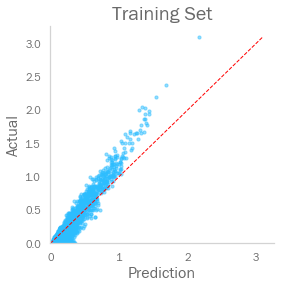

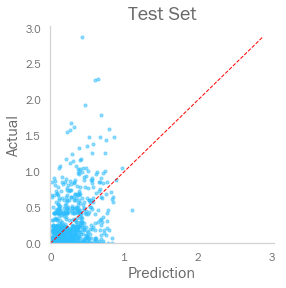

In [15]:
XG_forest_1 = RandomForestRegressor()
XG_forest_1.fit(X_train_XG, y_train_XG)
performance(XG_forest_1, X_train_XG, X_test_XG, y_train_XG, y_test_XG)

The forest isn't over-fitting quite as badly as the single tree, but it's not giving us the kind of accuracy on the test set that we'd be happy with.

Let's try the other targets.


_________R2_________

Train R2: 0.8899
Test R2: 0.1819

Train Adj R2: 0.8871
Test Adj R2: 0.1166

_________MSE________

Train MSE: 0.0117
Test MSE: 0.0743

Train RMSE: 0.1081
Test RMSE: 0.2725


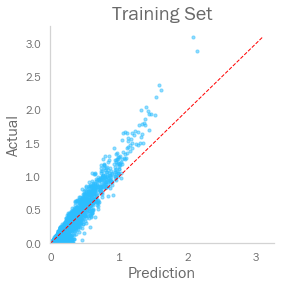

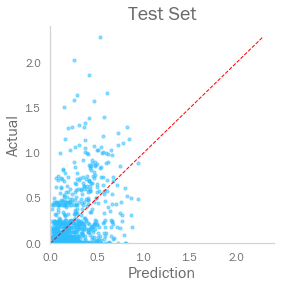

In [16]:
XA_forest_1 = RandomForestRegressor()
XA_forest_1.fit(X_train_XA, y_train_XA)
performance(XA_forest_1, X_train_XA, X_test_XA, y_train_XA, y_test_XA)


_________R2_________

Train R2: 0.8907
Test R2: 0.2018

Train Adj R2: 0.8879
Test Adj R2: 0.1381

_________MSE________

Train MSE: 0.0113
Test MSE: 0.0804

Train RMSE: 0.1061
Test RMSE: 0.2836


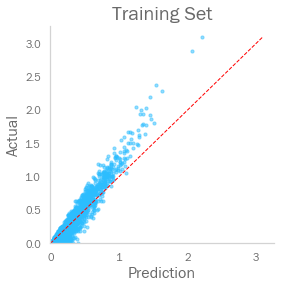

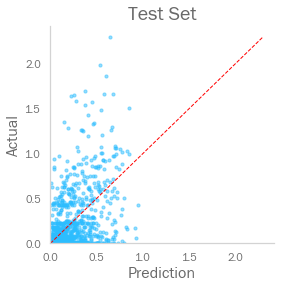

In [17]:
XGI_forest_1 = RandomForestRegressor()
XGI_forest_1.fit(X_train_XGI, y_train_XGI)
performance(XGI_forest_1, X_train_XGI, X_test_XGI, y_train_XGI, y_test_XGI)

## Gridsearching

Let's try gridsearching to improve the forest performance.

In [7]:
regressor = RandomForestRegressor()

#Create a parameter grid, and run it through the GridSearch class
param_grid = {
    "n_estimators": [20, 50],
    "criterion": ['mse'],
    "max_depth": [2,5,10,None],
    "min_samples_split": [2,5,10],
    "max_features": ['log2',30],
}


XG_ForestGS = GridSearchCV(regressor, param_grid, cv=4,
                      scoring='neg_mean_squared_error', verbose=40)

XG_ForestGS.fit(X_train_XG, y_train_XG)

Fitting 4 folds for each of 48 candidates, totalling 192 fits
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=2, n_estimators=20 
[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=2, n_estimators=20, score=-0.072, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=2, n_estimators=20 
[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=2, n_estimators=20, score=-0.083, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=2, n_estimators=20 
[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=2, n_estimators=20, score=-0.083, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=2, n_estimators=20 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=2, n_estimators=20, score=-0.081, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=2, n_estimators=50 
[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=2, n_estimators=50, score=-0.071, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=2, n_estimators=50, score=-0.082, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=2, n_estimators=50 
[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=2, n_estimators=50, score=-0.083, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=2, n_estimators=50, score=-0.081, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=5, n_estimators=20 
[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=5, n_estimators=20, score=-0.071, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=5, n_estimators=20 
[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=5, n_estimators=20, score=-0.083, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=5, n_estimators=20 
[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=5, n_estimators=20, score=-0.082, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=5, n_estimators=20 
[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=5, n_estimators=20, score=-0.080, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.9s remaining:    0.0s


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=5, n_estimators=50, score=-0.071, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=5, n_estimators=50 
[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=5, n_estimators=50, score=-0.083, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.1s remaining:    0.0s


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=5, n_estimators=50, score=-0.082, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=5, n_estimators=50 
[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=5, n_estimators=50, score=-0.081, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=10, n_estimators=20 
[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=10, n_estimators=20, score=-0.071, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=10, n_estimators=20 


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    1.4s remaining:    0.0s


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=10, n_estimators=20, score=-0.083, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=10, n_estimators=20 
[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=10, n_estimators=20, score=-0.082, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=10, n_estimators=20 
[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=10, n_estimators=20, score=-0.081, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=10, n_estimators=50 


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.6s remaining:    0.0s


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=10, n_estimators=50, score=-0.071, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=10, n_estimators=50 
[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=10, n_estimators=50, score=-0.085, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=10, n_estimators=50 


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    1.8s remaining:    0.0s


[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=10, n_estimators=50, score=-0.082, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_split=10, n_estimators=50 
[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_split=10, n_estimators=50, score=-0.082, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=30, min_samples_split=2, n_estimators=20 


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    2.1s remaining:    0.0s


[CV]  criterion=mse, max_depth=2, max_features=30, min_samples_split=2, n_estimators=20, score=-0.070, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=30, min_samples_split=2, n_estimators=20 
[CV]  criterion=mse, max_depth=2, max_features=30, min_samples_split=2, n_estimators=20, score=-0.079, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=30, min_samples_split=2, n_estimators=20 


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    2.3s remaining:    0.0s


[CV]  criterion=mse, max_depth=2, max_features=30, min_samples_split=2, n_estimators=20, score=-0.083, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=30, min_samples_split=2, n_estimators=20 
[CV]  criterion=mse, max_depth=2, max_features=30, min_samples_split=2, n_estimators=20, score=-0.079, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=30, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    2.6s remaining:    0.0s


[CV]  criterion=mse, max_depth=2, max_features=30, min_samples_split=2, n_estimators=50, score=-0.069, total=   0.3s
[CV] criterion=mse, max_depth=2, max_features=30, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    2.8s remaining:    0.0s


[CV]  criterion=mse, max_depth=2, max_features=30, min_samples_split=2, n_estimators=50, score=-0.079, total=   0.3s
[CV] criterion=mse, max_depth=2, max_features=30, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.1s remaining:    0.0s


[CV]  criterion=mse, max_depth=2, max_features=30, min_samples_split=2, n_estimators=50, score=-0.083, total=   0.3s
[CV] criterion=mse, max_depth=2, max_features=30, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    3.4s remaining:    0.0s


[CV]  criterion=mse, max_depth=2, max_features=30, min_samples_split=2, n_estimators=50, score=-0.079, total=   0.3s
[CV] criterion=mse, max_depth=2, max_features=30, min_samples_split=5, n_estimators=20 
[CV]  criterion=mse, max_depth=2, max_features=30, min_samples_split=5, n_estimators=20, score=-0.070, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=30, min_samples_split=5, n_estimators=20 


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    3.7s remaining:    0.0s


[CV]  criterion=mse, max_depth=2, max_features=30, min_samples_split=5, n_estimators=20, score=-0.080, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=30, min_samples_split=5, n_estimators=20 
[CV]  criterion=mse, max_depth=2, max_features=30, min_samples_split=5, n_estimators=20, score=-0.083, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=30, min_samples_split=5, n_estimators=20 


[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    4.0s remaining:    0.0s


[CV]  criterion=mse, max_depth=2, max_features=30, min_samples_split=5, n_estimators=20, score=-0.079, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=30, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    4.1s remaining:    0.0s


[CV]  criterion=mse, max_depth=2, max_features=30, min_samples_split=5, n_estimators=50, score=-0.069, total=   0.3s
[CV] criterion=mse, max_depth=2, max_features=30, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    4.3s remaining:    0.0s


[CV]  criterion=mse, max_depth=2, max_features=30, min_samples_split=5, n_estimators=50, score=-0.079, total=   0.3s
[CV] criterion=mse, max_depth=2, max_features=30, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    4.6s remaining:    0.0s


[CV]  criterion=mse, max_depth=2, max_features=30, min_samples_split=5, n_estimators=50, score=-0.083, total=   0.2s
[CV] criterion=mse, max_depth=2, max_features=30, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    4.9s remaining:    0.0s


[CV]  criterion=mse, max_depth=2, max_features=30, min_samples_split=5, n_estimators=50, score=-0.079, total=   0.3s
[CV] criterion=mse, max_depth=2, max_features=30, min_samples_split=10, n_estimators=20 
[CV]  criterion=mse, max_depth=2, max_features=30, min_samples_split=10, n_estimators=20, score=-0.069, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=30, min_samples_split=10, n_estimators=20 
[CV]  criterion=mse, max_depth=2, max_features=30, min_samples_split=10, n_estimators=20, score=-0.079, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=30, min_samples_split=10, n_estimators=20 
[CV]  criterion=mse, max_depth=2, max_features=30, min_samples_split=10, n_estimators=20, score=-0.083, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=30, min_samples_split=10, n_estimators=20 
[CV]  criterion=mse, max_depth=2, max_features=30, min_samples_split=10, n_estimators=20, score=-0.079, total=   0.1s
[CV] criterion=mse, max_depth=2, max_features=30, min_s

[CV]  criterion=mse, max_depth=5, max_features=30, min_samples_split=2, n_estimators=50, score=-0.076, total=   0.6s
[CV] criterion=mse, max_depth=5, max_features=30, min_samples_split=5, n_estimators=20 
[CV]  criterion=mse, max_depth=5, max_features=30, min_samples_split=5, n_estimators=20, score=-0.068, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=30, min_samples_split=5, n_estimators=20 
[CV]  criterion=mse, max_depth=5, max_features=30, min_samples_split=5, n_estimators=20, score=-0.079, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=30, min_samples_split=5, n_estimators=20 
[CV]  criterion=mse, max_depth=5, max_features=30, min_samples_split=5, n_estimators=20, score=-0.084, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=30, min_samples_split=5, n_estimators=20 
[CV]  criterion=mse, max_depth=5, max_features=30, min_samples_split=5, n_estimators=20, score=-0.077, total=   0.2s
[CV] criterion=mse, max_depth=5, max_features=30, min_samples_s

[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_split=10, n_estimators=50, score=-0.075, total=   0.3s
[CV] criterion=mse, max_depth=10, max_features=30, min_samples_split=2, n_estimators=20 
[CV]  criterion=mse, max_depth=10, max_features=30, min_samples_split=2, n_estimators=20, score=-0.071, total=   0.4s
[CV] criterion=mse, max_depth=10, max_features=30, min_samples_split=2, n_estimators=20 
[CV]  criterion=mse, max_depth=10, max_features=30, min_samples_split=2, n_estimators=20, score=-0.082, total=   0.4s
[CV] criterion=mse, max_depth=10, max_features=30, min_samples_split=2, n_estimators=20 
[CV]  criterion=mse, max_depth=10, max_features=30, min_samples_split=2, n_estimators=20, score=-0.087, total=   0.4s
[CV] criterion=mse, max_depth=10, max_features=30, min_samples_split=2, n_estimators=20 
[CV]  criterion=mse, max_depth=10, max_features=30, min_samples_split=2, n_estimators=20, score=-0.078, total=   0.4s
[CV] criterion=mse, max_depth=10, max_features=30, 

[CV]  criterion=mse, max_depth=None, max_features=log2, min_samples_split=5, n_estimators=50, score=-0.083, total=   0.5s
[CV] criterion=mse, max_depth=None, max_features=log2, min_samples_split=5, n_estimators=50 
[CV]  criterion=mse, max_depth=None, max_features=log2, min_samples_split=5, n_estimators=50, score=-0.077, total=   0.5s
[CV] criterion=mse, max_depth=None, max_features=log2, min_samples_split=10, n_estimators=20 
[CV]  criterion=mse, max_depth=None, max_features=log2, min_samples_split=10, n_estimators=20, score=-0.073, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=log2, min_samples_split=10, n_estimators=20 
[CV]  criterion=mse, max_depth=None, max_features=log2, min_samples_split=10, n_estimators=20, score=-0.076, total=   0.2s
[CV] criterion=mse, max_depth=None, max_features=log2, min_samples_split=10, n_estimators=20 
[CV]  criterion=mse, max_depth=None, max_features=log2, min_samples_split=10, n_estimators=20, score=-0.085, total=   0.2s
[CV] criteri

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:  1.3min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [8]:
with open('Models/XG_ForestGS.pickle', 'wb') as f:
    pickle.dump(XG_ForestGS, f, pickle.HIGHEST_PROTOCOL)

with open('Models/XG_ForestGS.pickle', 'rb') as f:
    XG_ForestGS = pickle.load(f)

{'criterion': 'mse', 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 50} 


_________R2_________

Train R2: 0.6156
Test R2: 0.2229

Train Adj R2: 0.6059
Test Adj R2: 0.1609

_________MSE________

Train MSE: 0.039
Test MSE: 0.0819

Train RMSE: 0.1974
Test RMSE: 0.2862


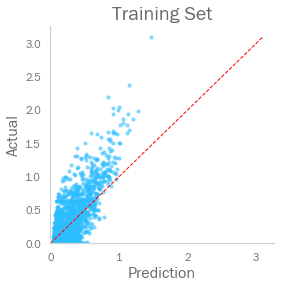

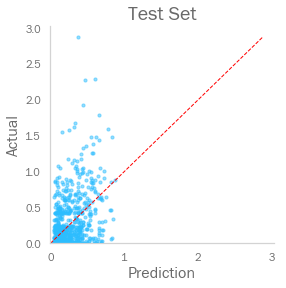

In [18]:
print(XG_ForestGS.best_params_, '\n')
XG_forest_2 = XG_ForestGS.best_estimator_
performance(XG_forest_2, X_train_XG, X_test_XG, y_train_XG, y_test_XG)

In [10]:
regressor = RandomForestRegressor()

#Create a parameter grid, and run it through the GridSearch class
param_grid = {
    "n_estimators": [20, 50],
    "criterion": ['mse'],
    "max_depth": [2,5,10,None],
    "min_samples_split": [2,5,10],
    "max_features": ['log2',30],
}


XGI_ForestGS = GridSearchCV(regressor, param_grid, cv=4, n_jobs=-1,
                      scoring='neg_mean_squared_error', verbose=True)

XGI_ForestGS.fit(X_train_XGI, y_train_XGI)

Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   57.8s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [11]:
with open('Models/XGI_ForestGS.pickle', 'wb') as f:
    pickle.dump(XGI_ForestGS, f, pickle.HIGHEST_PROTOCOL)

with open('Models/XGI_ForestGS.pickle', 'rb') as f:
    XGI_ForestGS = pickle.load(f)

{'criterion': 'mse', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 50} 


_________R2_________

Train R2: 0.3754
Test R2: 0.2395

Train Adj R2: 0.3596
Test Adj R2: 0.1788

_________MSE________

Train MSE: 0.0643
Test MSE: 0.0766

Train RMSE: 0.2536
Test RMSE: 0.2768


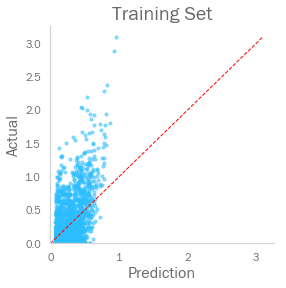

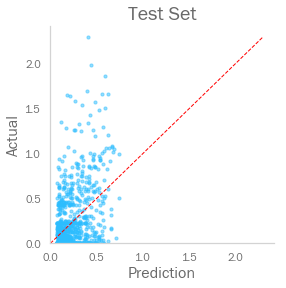

In [19]:
print(XGI_ForestGS.best_params_, '\n')
XGI_forest_2 = XGI_ForestGS.best_estimator_
performance(XGI_forest_2, X_train_XGI, X_test_XGI, y_train_XGI, y_test_XGI)